In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow info logs

import keras
from keras.models import Model
from keras.layers import Dense, Input, Concatenate
from keras.optimizers import Adam
import tensorflow as tf
from sklearn.feature_selection import mutual_info_regression

import matplotlib.pyplot as plt
import numpy as np

import pisces.data_sets as pds
from pisces.utils import build_ADS
from models import *

2024-12-06 16:14:53.067688: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733523293.077768 1593186 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733523293.080722 1593186 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/home/eric/miniconda3/envs/pisces/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Regression Mutual Info

In [2]:

# Load the dataset
DATA_DIR = '../../data'
sets = pds.DataSetObject.find_data_sets(DATA_DIR)


In [3]:
sets.keys()

dict_keys(['hybrid_motion', 'hf_disordered', 'walch_et_al'])

In [4]:
walch = sets['walch_et_al']
walch.parse_data_sets()

In [5]:
w0_id = walch.ids[0]
w0_acc = walch.get_feature_data('accelerometer', w0_id)
w0_psg = walch.get_feature_data('psg', w0_id)
w0_activity_time, w0_activity = build_ADS(w0_acc, resample_hz=32, bin_size_seconds=30)

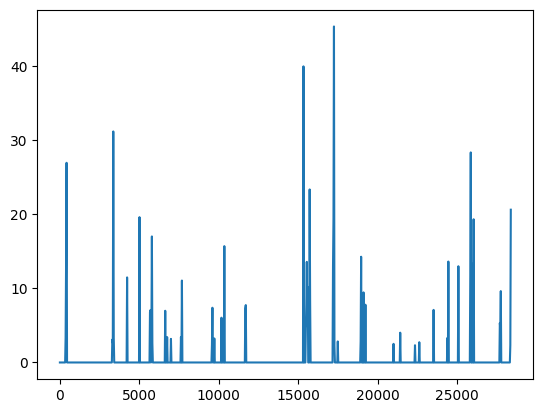

In [6]:

plt.plot(w0_activity_time, w0_activity)

In [7]:
def rolling_window(x: np.ndarray, window_size: int) -> np.ndarray:
    """
    Create a rolling window view of the input array.
    """
    return np.lib.stride_tricks.sliding_window_view(x, window_shape=(window_size,))

def stretch_to_range(x, low, high):
    """
    Stretch the input array to the range [low, high].
    """
    return (x - np.min(x)) / (np.max(x) - np.min(x)) * (high - low) + low

In [8]:
sw_psg = np.where(w0_psg[:, 1] > 0, 1, w0_psg[:, 1])

In [9]:
WINDOW = 61
activity_01 = stretch_to_range(w0_activity, 0, 1)
wrapped_activity = rolling_window(activity_01, WINDOW)

wrapped_time = rolling_window(w0_activity_time, WINDOW)

In [10]:
wrapped_activity.shape

(887, 61)

In [11]:
w0_activity.shape

(947,)

In [12]:
n_windows = wrapped_activity.shape[0]

neighbors = list(range(3, 10))


mi = np.array([
    mutual_info_regression(wrapped_activity[:-1], w0_activity[WINDOW:], n_neighbors=N)
    for N in neighbors
])

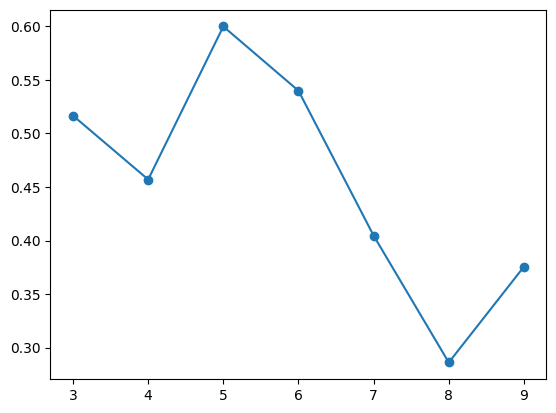

In [13]:
plt.plot(neighbors, np.sum(mi, axis=-1), 'o-')

# KSG Estimator for MI
The sklearn function `mutual_info_regression` uses the KSG estimator for mutual information. However, the implementation parallizes along the input vector `X` and treats each as a separate query against the (strictly 1-dimensional) `y`. However, for a convolutional kernel, the input vector `X` is the entire sub-vector of the original that's covered by the kernel. We go back to the original publication and use the ideas, making a k-Nearest Neighbor algorithm that does not make these assumptions.

In [14]:
def generate_correlated_normals(shape, R):
    """
    Generate two arrays X and Y of length N, both standard normal with correlation R.

    Parameters
    ----------
    N : int
        Number of samples.
    R : float
        Desired correlation between X and Y. Must be in [-1, 1].

    Returns
    -------
    X : ndarray of shape (N,)
        Samples from a standard normal distribution.
    Y : ndarray of shape (N,)
        Samples from a standard normal distribution correlated with X.
    """
    # Generate X ~ N(0, 1)
    X = np.random.standard_normal(shape)

    # Generate Z ~ N(0, 1) independent of X
    Z = np.random.standard_normal(shape)

    # Create Y with correlation R
    Y = R * X + np.sqrt(1 - R**2) * Z

    return X, Y

In [15]:
import numpy as np
from scipy.special import digamma as psi
from scipy.spatial import KDTree

def mutual_information_ksg(X, Y, k=5):
    """
    Estimate the mutual information between multi-dimensional variables X and Y 
    using the Kraskov-Stögbauer-Grassberger (KSG) estimator (KSG1).

    Parameters
    ----------
    X : ndarray of shape (N, d_x)
        Samples of random variable X.
    Y : ndarray of shape (N, d_y)
        Samples of random variable Y.
    k : int
        Number of nearest neighbors to use.

    Returns
    -------
    MI : float
        Estimated mutual information I(X; Y).
    """
    X = np.asarray(X, dtype=float)
    Y = np.asarray(Y, dtype=float)

    N = X.shape[0]
    if Y.shape[0] != N:
        raise ValueError("X and Y must have the same number of samples. Got %d and %d." % (N, Y.shape[0]))
    d_x = X.shape[1] if X.ndim > 1 else 1
    d_y = Y.shape[1] if Y.ndim > 1 else 1

    # Build KD Trees
    XY = np.hstack((X, Y))
    xy_tree = KDTree(XY)
    x_tree = KDTree(X)
    y_tree = KDTree(Y)

    # Find the distance to the k-th nearest neighbor in the joint space
    distances, _ = xy_tree.query(XY, k=k+1)
    kth_dist = distances[:, k]

    # Count neighbors in X and Y within the radius defined by the k-th NN distance
    n_x = np.empty(N, dtype=int)
    n_y = np.empty(N, dtype=int)

    for i in range(N):
        radius = kth_dist[i]

        # Count neighbors in X space
        nx_neighbors = x_tree.query_ball_point(X[i], r=radius)
        n_x[i] = len(nx_neighbors)

        # Count neighbors in Y space
        ny_neighbors = y_tree.query_ball_point(Y[i], r=radius)
        n_y[i] = len(ny_neighbors)

    # Apply the KSG estimator formula
    # I(X; Y) = psi(k) + psi(N) - (1/N)*sum[psi(n_x) + psi(n_y)]
    MI = psi(k) - 1/k + psi(N) - np.mean(psi(n_x) + psi(n_y))
    return MI

# Example usage:
# Generate some sample data
R = 0.5

X, Y = generate_correlated_normals((10000, 1), R)

mi_est = mutual_information_ksg(X, Y, k=2)
print("Estimated MI:", mi_est)
print("Theoretical MI:", -0.5 * np.log(1 - R**2))


Estimated MI: -0.6008075309000382
Theoretical MI: 0.14384103622589045


In [16]:
w0_psg.shape

(951, 2)

In [17]:
type(w0_psg)

polars.dataframe.frame.DataFrame

In [18]:
mutual_information_ksg(wrapped_activity, sw_psg[WINDOW:-3].reshape(-1, 1), k=5)

np.float64(-0.9947911570853041)

# MINE

In [20]:

class MINE(Model):
    def __init__(self, input_dim, hidden_dim):
        super(MINE, self).__init__()
        # Define the network for MI estimation
        self.dense1 = Dense(hidden_dim, activation='relu')
        self.dense2 = Dense(hidden_dim, activation='relu')
        self.output_layer = Dense(1)
    
    def call(self, x, y):
        # Joint distribution input
        joint_input = Concatenate(axis=1)([x, y])
        joint_score = self.output_layer(self.dense2(self.dense1(joint_input)))
        
        # Marginal distribution input (shuffled y)
        shuffled_y = tf.random.shuffle(y)
        marginal_input = Concatenate(axis=1)([x, shuffled_y])
        marginal_score = self.output_layer(self.dense2(self.dense1(marginal_input)))
        
        return joint_score, marginal_score


In [21]:
def train_mine(mine_model, x, y, epochs=1000, lr=1e-3, batch_size=128):
    optimizer = Adam(learning_rate=lr)

    # Custom training step
    @tf.function
    def train_step(x_batch, y_batch):
        with tf.GradientTape() as tape:
            # Forward pass
            joint_score, marginal_score = mine_model(x_batch, y_batch)
            
            # MI estimation
            mi_estimation = tf.reduce_mean(joint_score) - tf.math.log(tf.reduce_mean(tf.exp(marginal_score)))
            
            # Loss for optimization (negative MI)
            loss = -mi_estimation
        
        # Backpropagation
        gradients = tape.gradient(loss, mine_model.trainable_variables)
        clipped_gradients = [tf.clip_by_value(g, -5.0, 5.0) for g in gradients]
        optimizer.apply_gradients(zip(clipped_gradients, mine_model.trainable_variables))
        
        return mi_estimation

    # Prepare dataset
    dataset = tf.data.Dataset.from_tensor_slices((x, y)).shuffle(buffer_size=1024).batch(batch_size)
    
    for epoch in range(epochs):
        for x_batch, y_batch in dataset:
            mi_estimation = train_step(x_batch, y_batch)
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, MI Estimation: {mi_estimation.numpy()}")
    
    return mi_estimation.numpy()


def train_mine_with_logging(mine_model, x, y, epochs=1000, lr=1e-3, batch_size=128):
    optimizer = Adam(learning_rate=lr)
    mi_history = []

    @tf.function
    def train_step(x_batch, y_batch):
        with tf.GradientTape() as tape:
            joint_score, marginal_score = mine_model(x_batch, y_batch)
            mi_estimation = tf.reduce_mean(joint_score) - tf.math.log(tf.reduce_mean(tf.exp(marginal_score)))
            loss = -mi_estimation
        gradients = tape.gradient(loss, mine_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, mine_model.trainable_variables))
        return mi_estimation

    dataset = tf.data.Dataset.from_tensor_slices((x, y)).shuffle(buffer_size=1024).batch(batch_size)

    for epoch in range(epochs):
        for x_batch, y_batch in dataset:
            mi_estimation = train_step(x_batch, y_batch)
        mi_history.append(mi_estimation.numpy())
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, MI Estimation: {mi_estimation.numpy()}")

    return mi_history



I0000 00:00:1733523296.638628 1593186 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9897 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 0, MI Estimation: 0.0038714101538062096
Epoch 100, MI Estimation: 1.1638585329055786
Epoch 200, MI Estimation: 1.0161364078521729
Epoch 300, MI Estimation: 1.0014214515686035
Epoch 400, MI Estimation: 1.1823642253875732
Epoch 500, MI Estimation: 0.9595756530761719
Epoch 600, MI Estimation: 1.165649652481079
Epoch 700, MI Estimation: 0.7255353927612305
Epoch 800, MI Estimation: 1.0606350898742676
Epoch 900, MI Estimation: 1.528268814086914


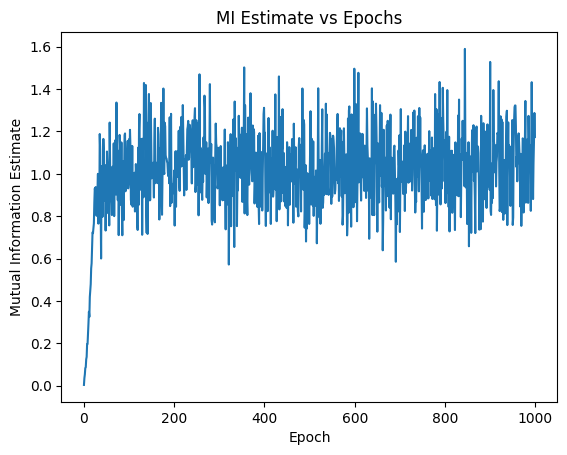

In [ ]:

# Example: Generate random data
# Instantiate and train MINE
mine_model = MINE(input_dim=2, hidden_dim=32)
# Training and logging
mi_history = train_mine_with_logging(mine_model, X, Y, epochs=1000, lr=1e-3, batch_size=128)

# Plot MI estimate
plt.plot(range(len(mi_history)), mi_history)
plt.xlabel('Epoch')
plt.ylabel('Mutual Information Estimate')
plt.title('MI Estimate vs Epochs')
plt.show()


Epoch 0, MI Estimation: -0.011114358901977539
Epoch 100, MI Estimation: 0.1238182783126831
Epoch 200, MI Estimation: 0.16881811618804932
Epoch 300, MI Estimation: 0.12945163249969482
Epoch 400, MI Estimation: -0.059600651264190674
Epoch 500, MI Estimation: 0.06018626689910889
Epoch 600, MI Estimation: 0.06178879737854004
Epoch 700, MI Estimation: 0.09273898601531982
Epoch 800, MI Estimation: -0.013858824968338013
Epoch 900, MI Estimation: 0.050836265087127686


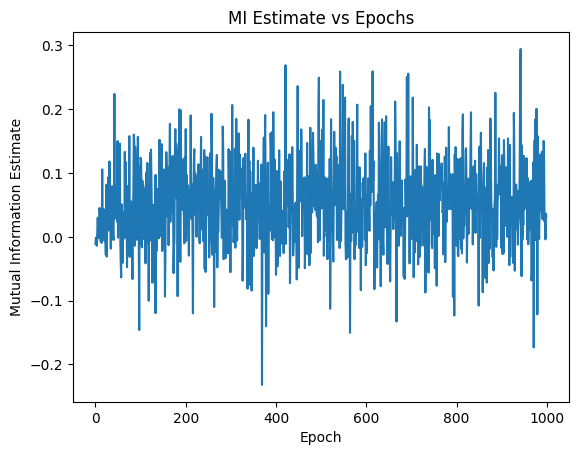

In [23]:
mine_model = MINE(input_dim=2, hidden_dim=32)

mine_x = w0_activity.reshape(-1, 1)
mine_y = w0_psg[:, 1].to_numpy().reshape(-1, 1)

# pad both arrays to be the same length
min_len = min(len(mine_x), len(mine_y))
mine_x = mine_x[:min_len]
mine_y = mine_y[:min_len]

# Training and logging
mi_history = train_mine_with_logging(mine_model, mine_x, mine_y,  epochs=1000, lr=1e-3, batch_size=128)

# Plot MI estimate
plt.plot(range(len(mi_history)), mi_history)
plt.xlabel('Epoch')
plt.ylabel('Mutual Information Estimate')
plt.title('MI Estimate vs Epochs')
plt.show()


1. Raw activity counts feature => one theoretical limit
2. Juiced activity (add circadian + homeostatic) => another higher theoretical limit

Useful for Navy 
- generate fake data driven by noisy 2 process model
- are we getting more information from the juiced activity?